In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD_test')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [19]:
%autoreload

pino = mre_pinn.model.SpectralOperator(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=128,
    n_channels_conv=32,
    n_conv_blocks=4,
    n_conv_per_block=1,
    activ_fn='g',
    omega=15/300
)
pino

SpectralOperator(
  (a_net): SpectralEncoder(
    (a_linear): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (x_linear): Linear(in_fe

In [20]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e0, 1e-1, 0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000270 s



<IPython.core.display.Javascript object>


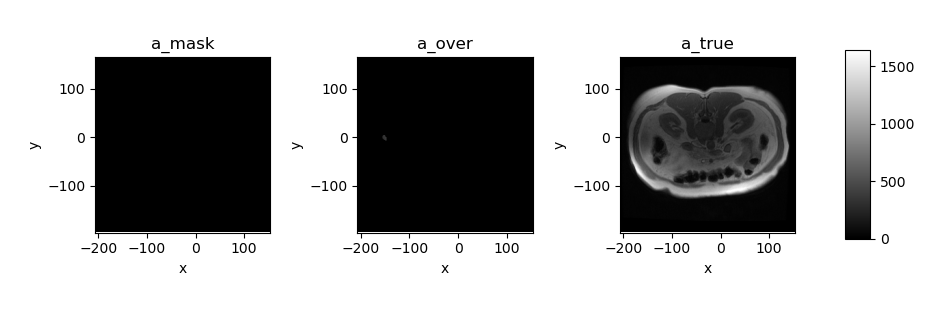

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


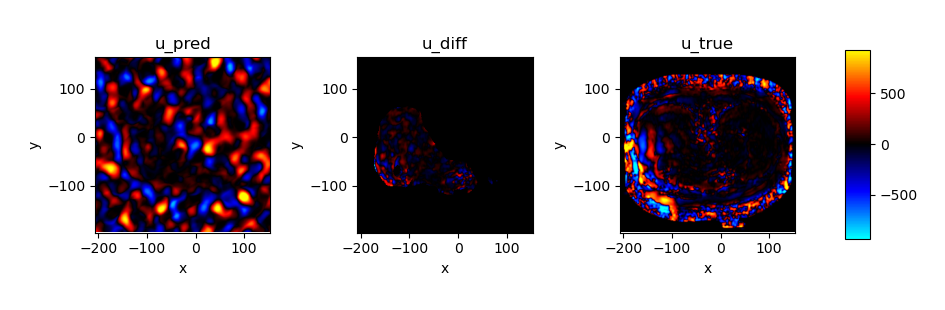

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


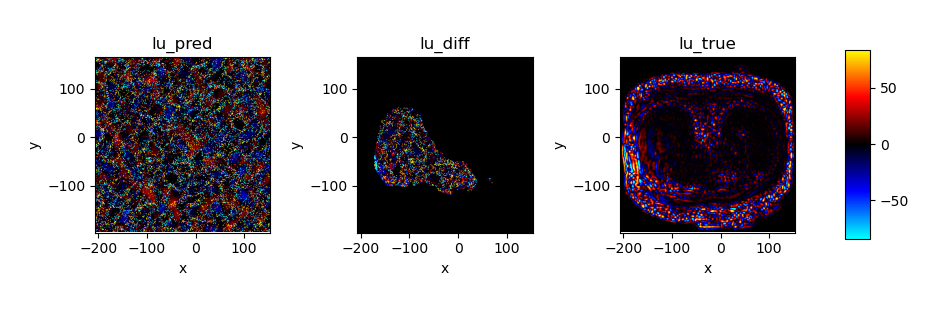

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


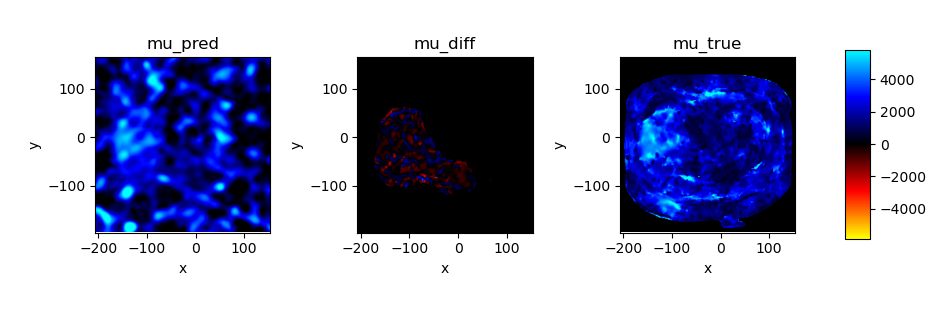

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [21]:
test_eval.model = model
test_eval.test()

In [ ]:
torch.backends.cudnn.enabled = False

model.train(10000, display_every=10, callbacks=[test_eval])

Training model...

0         [7.53e+03, 1.69e+05, 0.00e+00]    [7.53e+03, 1.69e+05, 0.00e+00]    []  
Time spent testing: 15.72%
10        [7.51e+03, 1.68e+05, 0.00e+00]    [7.51e+03, 1.68e+05, 0.00e+00]    []  
Time spent testing: 18.96%
20        [1.61e+04, 1.09e+05, 0.00e+00]    [1.61e+04, 1.09e+05, 0.00e+00]    []  
Time spent testing: 20.02%
30        [9.10e+03, 8.85e+04, 0.00e+00]    [9.10e+03, 8.85e+04, 0.00e+00]    []  
Time spent testing: 20.85%
40        [7.45e+03, 7.73e+04, 0.00e+00]    [7.45e+03, 7.73e+04, 0.00e+00]    []  
Time spent testing: 21.16%
50        [7.17e+03, 6.64e+04, 0.00e+00]    [7.17e+03, 6.64e+04, 0.00e+00]    []  
Time spent testing: 21.55%
60        [6.80e+03, 5.08e+04, 0.00e+00]    [6.80e+03, 5.08e+04, 0.00e+00]    []  
Time spent testing: 21.83%
70        [6.56e+03, 3.54e+04, 0.00e+00]    [6.56e+03, 3.54e+04, 0.00e+00]    []  
Time spent testing: 22.06%
80        [6.29e+03, 2.50e+04, 0.00e+00]    [6.29e+03, 2.50e+04, 0.00e+00]    []  
Time spent testing